## Import Libraries
### Import necessary libraries for data processing, visualization, model building, and evaluation.

In [25]:
import os
import time
import random
import soundfile as sf
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

import librosa
import librosa.display

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from keras._tf_keras.keras.models import Sequential, load_model
from keras._tf_keras.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras._tf_keras.keras.utils import to_categorical

# Set the dataset path
location = Path("Datasets/TESS/")

## Utility Functions for Feature Extraction and Data Augmentation
### Functions for extracting MFCC features, adding noise, time-shifting, and time-stretching.

In [26]:
def extract_mfcc_features(audio_path_or_waveform, sr=None, max_pad_len=500):
    # Extract MFCC features and pad them to ensure consistent length.
    if isinstance(audio_path_or_waveform, str):
        y, sr = librosa.load(audio_path_or_waveform, sr=sr)
    else:
        y = audio_path_or_waveform

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfccs.T

def add_noise(y, noise_factor=0.005):
    # Add Gaussian noise to audio.
    noise = np.random.randn(len(y))
    y_noise = y + noise_factor * noise
    return np.clip(y_noise, -1.0, 1.0)

def time_shift(y, shift_max=2):
    # Perform time-shifting on audio.
    shift = random.randint(-shift_max, shift_max)
    return np.roll(y, shift)

def time_stretch(y, rate=1.1):
    # Perform time-stretching on audio.
    return librosa.effects.time_stretch(y, rate=rate)

## Load Data Function
### This function loads the dataset, extracts features, and applies data augmentation if enabled.

In [27]:
def load_data(dataset_path, augment=False):
    # Load audio data, extract features, and apply data augmentation.
    features = []
    labels = []
    
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if not os.path.isdir(label_path):
            continue
        
        for file in os.listdir(label_path):
            if file.endswith(".wav"):  # Assuming audio files are in WAV format
                file_path = os.path.join(label_path, file)
                
                # Extract MFCC features from the original audio
                y, sr = librosa.load(file_path, sr=None)
                mfcc_features = extract_mfcc_features(y, sr=sr)
                features.append(mfcc_features)  # Add original features
                labels.append(label)
                
                if augment:
                    # Data Augmentation
                    features.append(extract_mfcc_features(add_noise(y), sr=sr))  # Noise-added
                    features.append(extract_mfcc_features(time_shift(y), sr=sr))  # Time-shifted
                    features.append(extract_mfcc_features(time_stretch(y, rate=1.1), sr=sr))  # Time-stretched
                    labels.extend([label] * 3)  # Same label for augmented samples
    
    # Convert labels to numerical values
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    
    # Pad or truncate features to have consistent shape
    max_length = max([x.shape[0] for x in features])
    features = [np.pad(x, ((0, max_length - x.shape[0]), (0, 0)), mode='constant') for x in features]
    
    return np.array(features), to_categorical(np.array(labels)), label_encoder

## Prepare Data
### Load and preprocess the dataset, including feature extraction and data splitting.

In [28]:
X, y, label_encoder = load_data(location, augment=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [29]:
X_train.shape

(8960, 500, 40)

In [30]:
X_test.shape

(2240, 500, 40)

#### Data Exploration

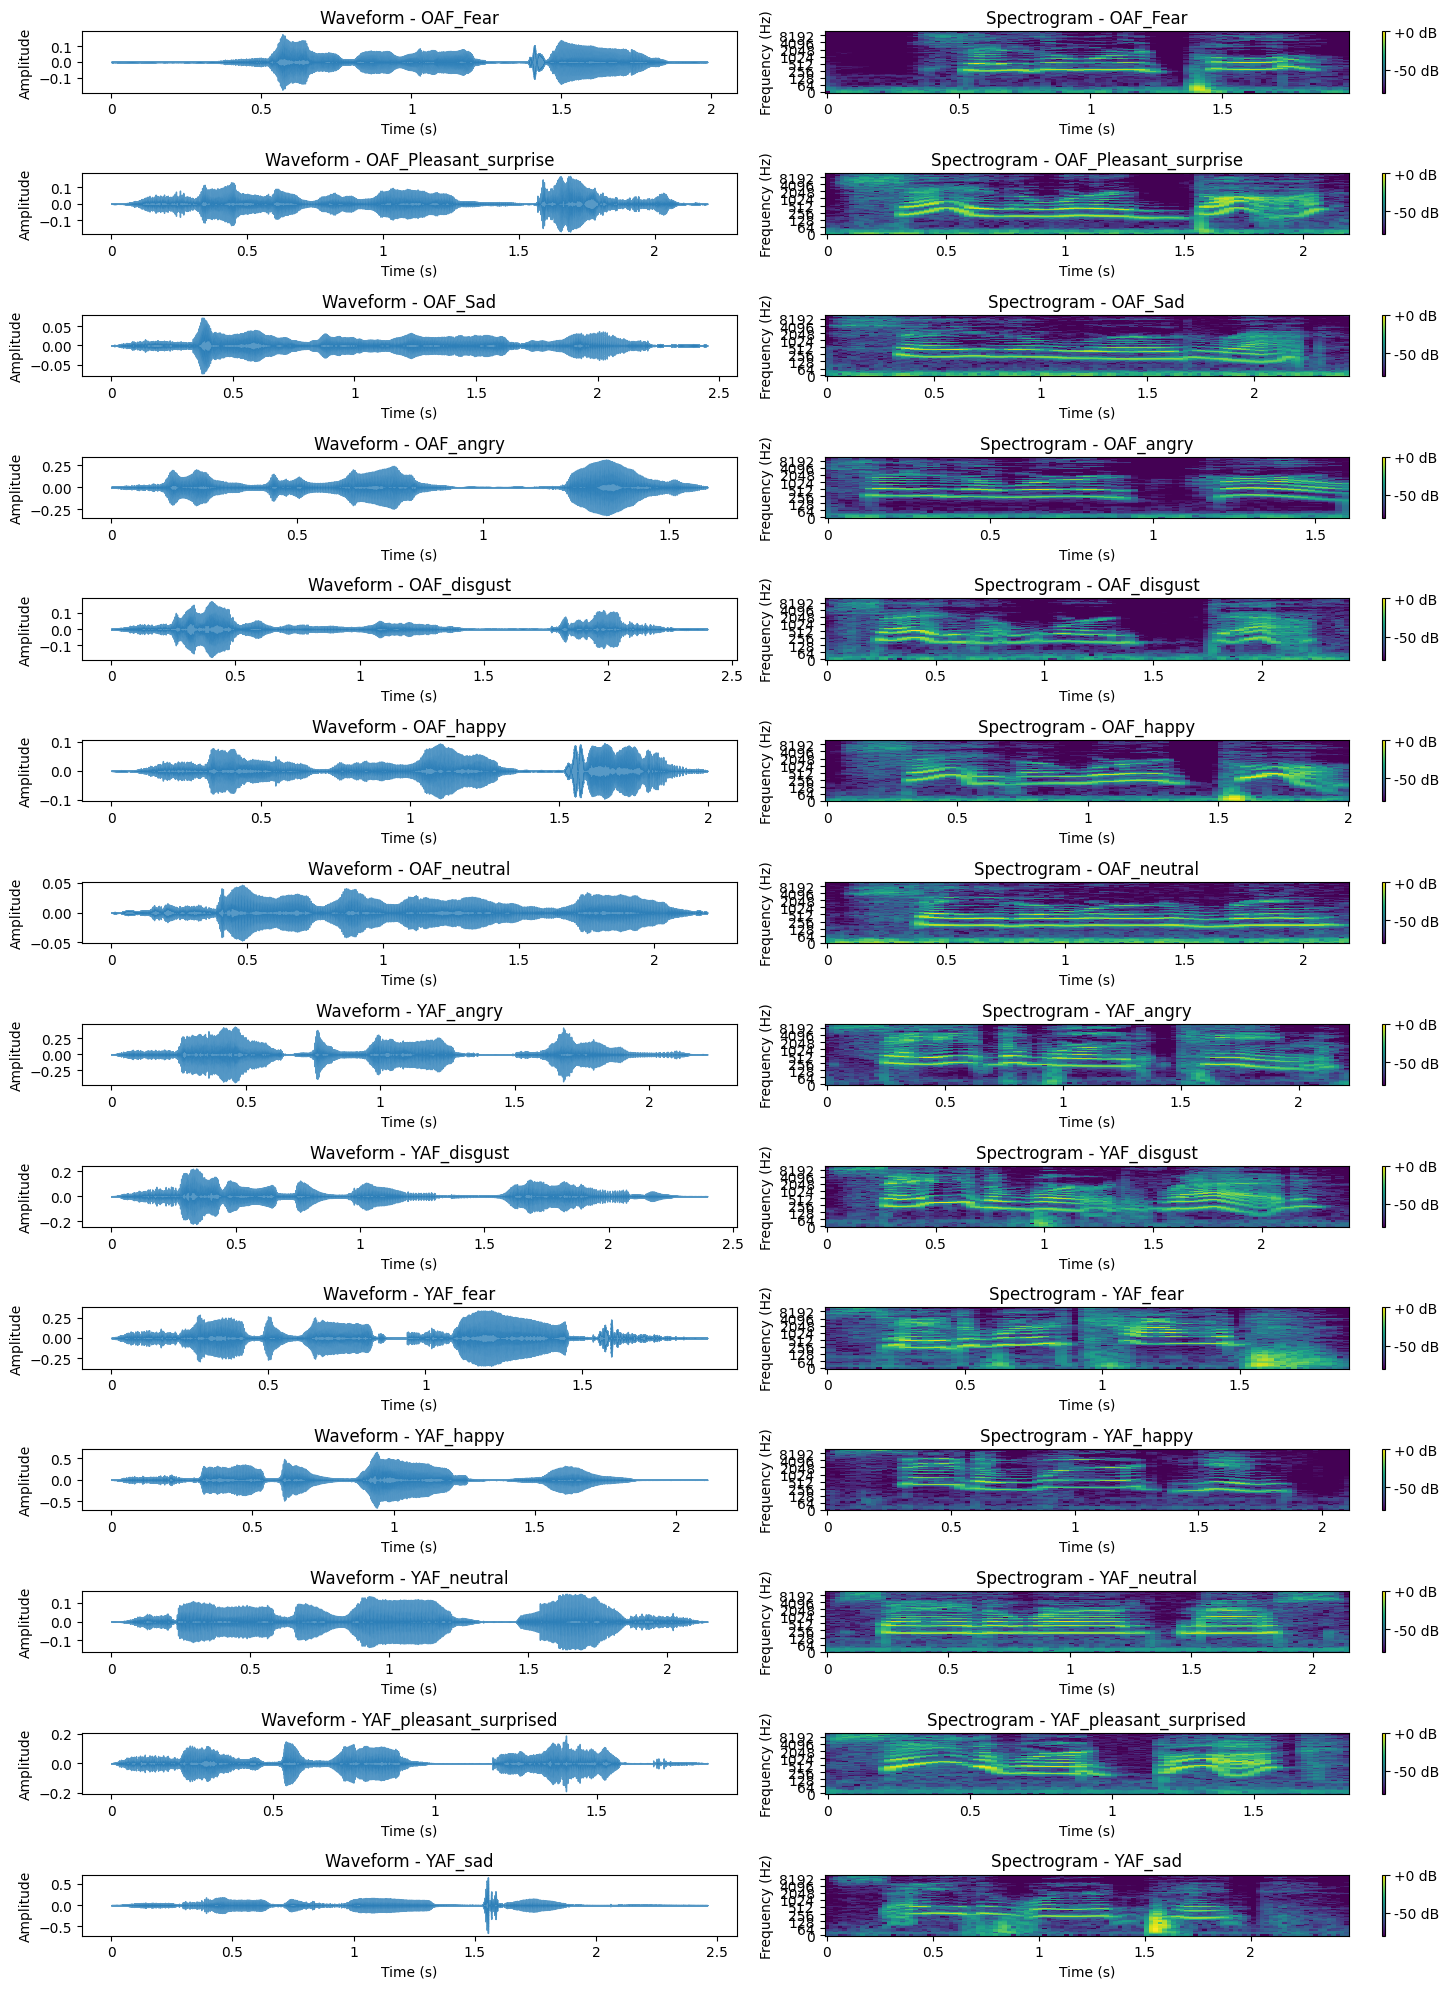

In [31]:
def plot_waveform_and_spectrogram(dataset_path, label_encoder, sample_rate=None):
    plt.figure(figsize=(15, 20))
    emotions = label_encoder.classes_

    for i, emotion in enumerate(emotions):
        emotion_path = os.path.join(dataset_path, emotion)
        if not os.path.exists(emotion_path):
            continue
        
        # Select a random audio file from the emotion folder
        audio_file = random.choice([f for f in os.listdir(emotion_path) if f.endswith('.wav')])
        audio_path = os.path.join(emotion_path, audio_file)
        
        # Load the audio file
        y, sr = librosa.load(audio_path, sr=sample_rate)
        
        # Plot waveform
        plt.subplot(len(emotions), 2, 2 * i + 1)
        librosa.display.waveshow(y, sr=sr, alpha=0.75)
        plt.title(f"Waveform - {emotion}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        # Compute and plot spectrogram
        plt.subplot(len(emotions), 2, 2 * i + 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
        plt.colorbar(format="%+2.0f dB")
        plt.title(f"Spectrogram - {emotion}")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()

plot_waveform_and_spectrogram(location, label_encoder)

## Build the LSTM (RNN) Model
### Define the model architecture, compile it

In [33]:
# Build the RNN model
model = Sequential()

# Add LSTM layers
Input(shape=(X_train.shape[1], X_train.shape[2])),
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))

# Output layer (softmax for multi-class classification)
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Train the Model

In [35]:
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.0686 - loss: 2.6815 - val_accuracy: 0.0714 - val_loss: 2.6495
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.0707 - loss: 2.6449 - val_accuracy: 0.0701 - val_loss: 2.6420
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.0833 - loss: 2.6180 - val_accuracy: 0.0701 - val_loss: 3.4063
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.0693 - loss: 2.6435 - val_accuracy: 0.0705 - val_loss: 2.6400
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.0745 - loss: 2.6398 - val_accuracy: 0.0661 - val_loss: 2.6400
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.0707 - loss: 2.6394 - val_accuracy: 0.0705 - val_loss: 2.8255
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.0656 - loss: 2.6396 - val_accuracy: 0.0661 - val_loss: 2.6404
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.0762 - loss: 2.6387 - val_accu

## Evaluate the Model
### Predict on the test data and calculate accuracy, precision, recall, and F1-score.

In [36]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate performance metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step
Accuracy: 0.9768
Precision: 0.9792
Recall: 0.9768
F1 Score: 0.9767


## Plot Training History
### Visualize the accuracy and loss during training.

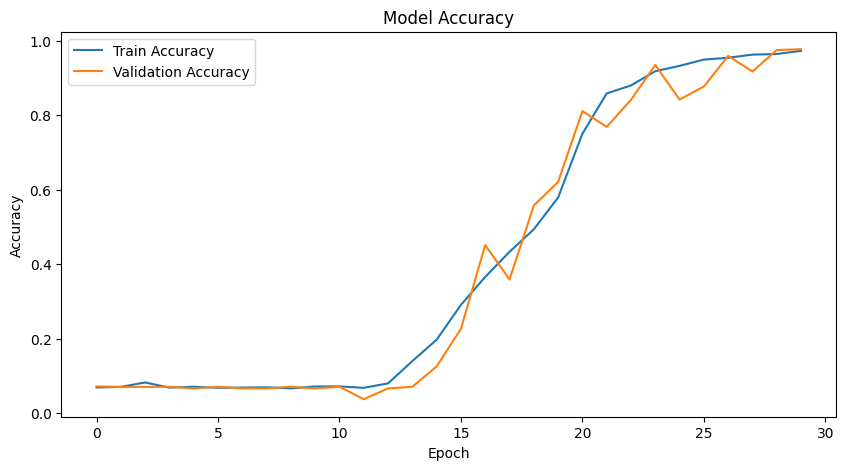

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Confusion Matrix Visualization
### Create and visualize a confusion matrix for model predictions.

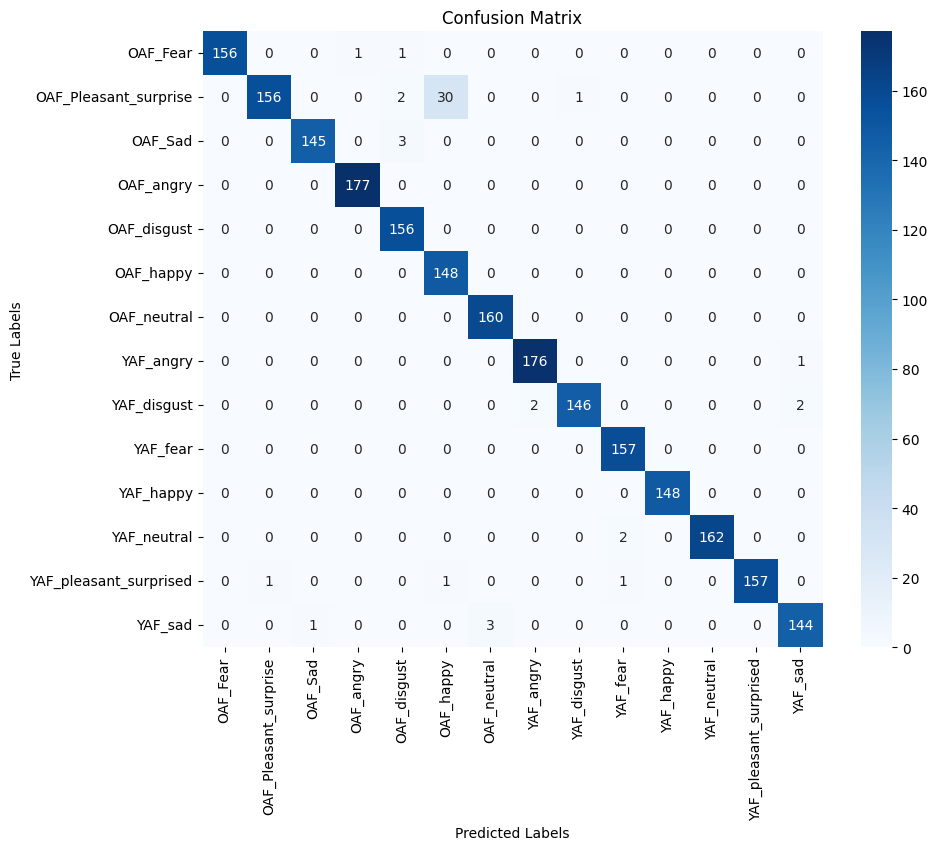

In [38]:
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
class_names = label_encoder.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Save the Trained Model
### Save the trained model in keras format for future use.

In [41]:
model_save_path = "Models/ser_model_30.keras"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to Models/ser_model_30.keras
